In [196]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr, spearmanr

import os
from env import username, password, host
import env

import wrangle

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [214]:
def acquire_zillow(use_cache=True):
    ''' 
    This function acquires all necessary housing data from zillow 
    needed to better understand future pricing
    '''
    
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cached csv')
        return pd.read_csv('zillow.csv')
    print('Acquiring data from SQL database')

    database_url_base = f'mysql+pymysql://{username}:{password}@{host}/zillow'
    query = '''
    SELECT bedroomcnt AS bedrooms, 
           bathroomcnt AS bathrooms, 
           calculatedfinishedsquarefeet AS sqft, 
           taxvaluedollarcnt AS tax_value, 
           yearbuilt AS yr_built,
           regionidcounty AS county_id,
           fips
        FROM properties_2017
    
        JOIN propertylandusetype USING(propertylandusetypeid)
        
        JOIN predictions_2017 pr USING (parcelid)
        WHERE propertylandusedesc IN ('Single Family Residential',
        
                                      'Inferred Single Family Residential')
                              AND pr.transactiondate LIKE '2017%%';
            '''
    
    
    df = pd.read_sql(query, database_url_base)
    df.to_csv('zillow.csv', index=False)
   
    return df

In [174]:
df = acquire_zillow()

Using cached csv


In [175]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,yr_built,tax_amount,county_id,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,1286.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,2061.0,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,1286.0,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,3101.0,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,3101.0,6037.0


In [176]:
df.shape

(52441, 8)

## Clean 

In [177]:
# def remove_outliers(df, k, col_list):
#     ''' 
#     This function remove outliers from a list of columns in a dataframe 
#     and returns that dataframe
#     '''
    
#     # Go through each column
#     for col in col_list:
        
#         # Get the quantiles
#         q1, q3 = df[col].quantile([.25, .75])
        
#         # Get the quantile range
#         iqr = q3 - q1
        
#         # Establish the upper and lower
#         upper_bound = q3 + k * iqr  
#         lower_bound = q1 - k * iqr   

#         # Redefine the DataFrame with removed outliers
#         df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
#     return df

In [178]:
# def clean_zillow(df):
#     '''
#     This function takes in the zillow data, cleans it, and returns a dataframe
#     '''
    
#     # Apply a function to remove outliers
#     df = remove_outliers(df, 1.5, ['bedrooms','bathrooms',
#                                    'sqft','tax_value','tax_amount'])
    
#     # Remove more of the outliers for sqft
#     df = df[(df.sqft > 500) & (df.sqft < 2500)]
#     # Remove more of the outliers for taxvalue
#     df = df[(df.tax_value > 500) & (df.tax_value < 800000)]
    
    # Drop rows with null values since it is only a small portion of the
#     dataframe 
#     df = df.dropna()

#     # Create list of datatypes to change
#     int_cols = ['bedrooms','sqft','tax_amount','age']
#     obj_cols = ['yr_built']
    
#     # Change data types of above columns
#     for col in df:
#         if col in int_cols:
#             df[col] = df[col].astype(int)
#         if col in obj_cols:
#             df[col] = df[col].astype(int).astype(object)
    
#     # Drop the target column
#     df = df.drop(columns='tax_value')
    
#     return df

In [179]:
# df = clean_zillow(df)

In [180]:
df = df.dropna()

In [193]:
df.isnull().sum()

bedrooms      0
bathrooms     0
sqft          0
tax_value     0
yr_built      0
tax_amount    0
county_id     0
fips          0
dtype: int64

In [215]:
# Create list of datatypes to change
int_cols = ['bedrooms','sqft', 'yr_built', 'fips']
# obj_cols = []

# Change data types of above columns
for col in df:
    if col in int_cols:
        df[col] = df[col].astype(int)
    if col in obj_cols:
        df[col] = df[col].astype(int).astype(object)


In [182]:
# # Drop the target column
# df = df.drop(columns='tax_value')

In [183]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,yr_built,tax_amount,county_id,fips
0,4,3.5,3100,1023282.0,1998,11013,1286.0,6059
1,2,1.0,1465,464000.0,1967,5672,2061.0,6111
2,3,2.0,1243,564778.0,1962,6488,1286.0,6059
3,4,3.0,2376,145143.0,1970,1777,3101.0,6037
4,4,3.0,2962,773303.0,1950,9516,3101.0,6037


## Split

In [184]:
# Split the data
train_val, test = train_test_split(df, 
                                   train_size=0.8, 
                                   random_state = 123) 
#                                    stratify = df['tax_value'])
    
    
train, validate = train_test_split(train_val, 
                                   train_size=0.7, 
                                   random_state=123) 
#                                    stratify = train['tax_value'])

In [185]:
train.shape, validate.shape, test.shape

((29296, 8), (12556, 8), (10463, 8))

## Exploration

In [216]:
# Create a function to use that takes in continuous columns and plots 
# Create continuous columns to plot
cont_cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value']

# Create a plot
def plot_variable_pairs(df):
    sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}}, corner = True)

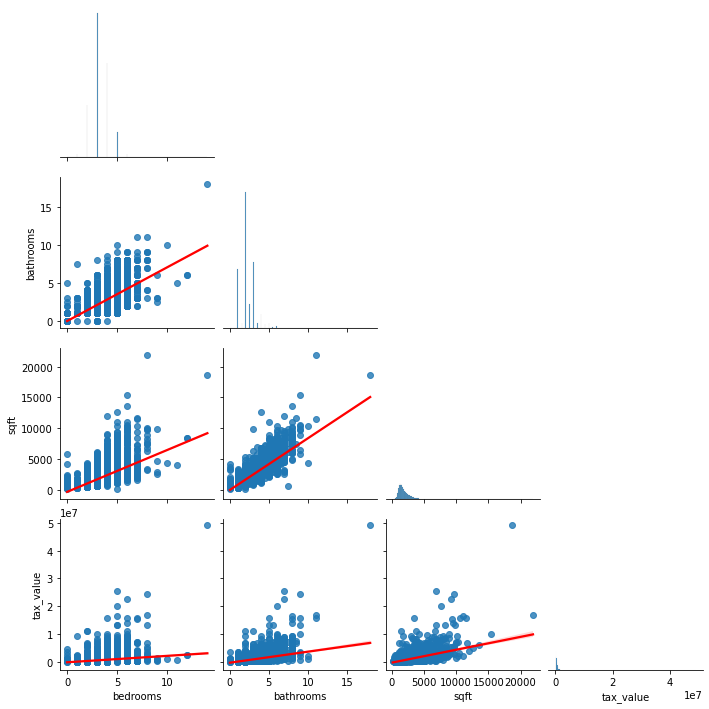

In [218]:
# Plug everything in
plot_variable_pairs(train[cont_cols])

In [ ]:
df_corr = train.corr().reset_index()
corr_matrix = train.corr()
corr_matrix['tax_value'].sort_values(ascending = False).reset_index()

### Exploratory Questions:
 - Does number of bedrooms effect tax value?
 - Does square footage effect tax value?

## Modeling / Feature Engineering

In [189]:
# Define the X and y's while dropping the target 
target = 'tax_value'
    
# split train into X (dataframe, drop target) & y (series, keep target only)
x_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
x_val = validate.drop(columns=[target])
y_val = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
x_test = test.drop(columns=[target])
y_test = test[target]

#### K_Best

In [190]:
# use SelectKBest to select top two features

# Make the model
kbest = SelectKBest(f_regression, k=3)

# Fit the thing
kbest.fit(x_train, y_train)

# Boolean mask of whether the column was selected or not. 
feature_mask = kbest.get_support()

# Use the thing to get list of top K features. 
kbest = x_train.iloc[:,feature_mask].columns.tolist()
print(f'kbest for predicting tax value are: {kbest}')

kbest for predicting tip are: ['bathrooms', 'sqft', 'tax_amount']


## Scaling

In [191]:
# Scale the numerical data to make it easier to compare
   
#Make the scaler
scaler = sklearn.preprocessing.MinMaxScaler()

#Fit the scaler
scaler.fit(x_train)

# Use the scaler
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

#### Recursive Feature Elimination

In [192]:
# use RFE to select top two features

# Make the things
lm = LinearRegression() 
rfe = RFE(lm, n_features_to_select=3)

# Fit the thing
rfe.fit(x_train, y_train)

# use the thing
rfe = x_train.columns[rfe.support_].tolist()
print(f'rfe for predicting tax value are: {rfe}')

rfe for predicting tip are: ['bedrooms', 'bathrooms', 'yr_built']


## Simple Model

In [219]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [220]:
predictions.head()

,actual
36356,869393.0
8203,594000.0
51688,341714.0
49648,237168.0
41798,535298.0


In [221]:
lm.coef_, lm.intercept_

(array([231140.09840731]), -236112.7474537507)

#### Make a model to predict tax value using number of bathrooms.

In [222]:
# Set x_train
x_train = train[['bathrooms']]
# Set y_train as target
y_train = train.tax_value

# Make the model
lm = LinearRegression()
# Fit the model
lm.fit(x_train, y_train)
# 3. Use the model
x_validate = validate[['bathrooms']]
predictions['simple_lm'] = lm.predict(x_validate)

In [223]:
print('Tax Value = {:.3f} * bathrooms {:.3f}'.format(lm.coef_[0], lm.intercept_))

Tax Value = 396058.467 * bathrooms -385384.860


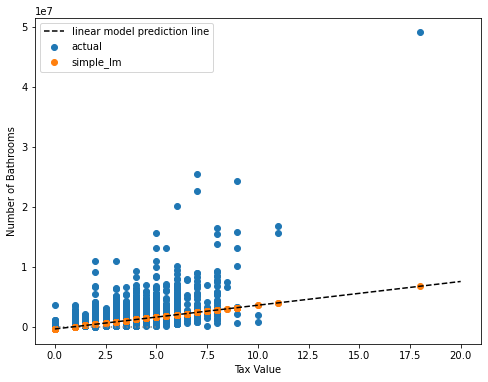

In [235]:
x_pred = np.array([0, 20]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(8, 6))
plt.scatter(train.bathrooms, train.tax_value, label='actual')
plt.scatter(train.bathrooms, lm.predict(train[['bathrooms']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, 0, 5, ls=':', color='grey')
plt.vlines(0, 0, 5, ls=':', color='grey')

plt.xlabel('Tax Value')
plt.ylabel('Number of Bathrooms')
plt.legend()

#### Make a model to predict tax value using number of bedrooms.

In [212]:
# Set x_train
x_train = train[['bedrooms']]
# Set y_train as target
y_train = train.tax_value

# Make the model
lm = LinearRegression()
# Fit the model
lm.fit(x_train, y_train)
# 3. Use the model
x_validate = validate[['bedrooms']]
predictions['simple_lm'] = lm.predict(x_validate)

In [213]:
print('Tax Value = {:.3f} * bedrooms {:.3f}'.format(lm.coef_[0], lm.intercept_))

Tax Value = 231140.098 * bedrooms -236112.747


ValueError: `bins` must increase monotonically, when an array

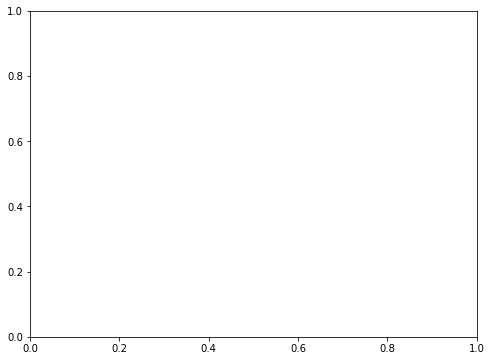

In [239]:
x_pred = np.array([0, 20]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(8, 6))
plt.hist(train.bedrooms, train.tax_value, label='actual')
plt.hist(train.bedrooms, lm.predict(train[['bedrooms']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, 0, 5, ls=':', color='grey')
plt.vlines(0, 0, 5, ls=':', color='grey')

plt.xlabel('Tax Value')
plt.ylabel('Number of Bedrooms')
plt.legend()